In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import mne
from mne.io import read_raw_ctf
from sklearn.model_selection import train_test_split
from load_dataset import *

In [4]:
train_x_orig, test_x_orig, train_y_orig, test_y_orig = load_dataset(window_size=0.1, test_size=0.2, random_state=0)

Start loading data...
From dataset: anonepi_02.ds
ds directory : /Users/mlion0200/GitRepo/bcni_epi/notebook/../data/anonepi_02.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.31   79.57   -0.00 mm <->    0.31   79.57    0.00 mm (orig :  -47.56   66.09 -265.98 mm) diff =    0.000 mm
      -0.31  -79.57   -0.00 mm <->   -0.31  -79.57    0.00 mm (orig :   56.93  -53.61 -274.89 mm) diff =    0.000 mm
     103.93   -0.00    0.00 mm <->  103.93   -0.00    0.00 mm (orig :   78.68   68.54 -232.42 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 21 EEG channels from channel info
    21 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /Users/mlion0200/GitRepo/bcni_epi/notebook/../data/anonepi_02.ds/anonepi_02.meg4: 
    System

In [8]:
train_x_array = np.asarray(train_x_orig)
test_x_array = np.asarray(test_x_orig)
train_y_array = np.asarray(train_y_orig)
test_y_array = np.asarray(test_y_orig)
m_train = train_x_array.shape[0]
num_px = train_x_array.shape[1]
m_test = test_x_array.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("train_x_orig shape: " + str(train_x_array.shape))
print ("train_y shape: " + str(train_y_array.shape))
print ("test_x_orig shape: " + str(test_x_array.shape))
print ("test_y shape: " + str(test_y_array.shape))

Number of training examples: 76
Number of testing examples: 20
train_x_orig shape: (76, 151, 61)
train_y shape: (76,)
test_x_orig shape: (20, 151, 61)
test_y shape: (20,)


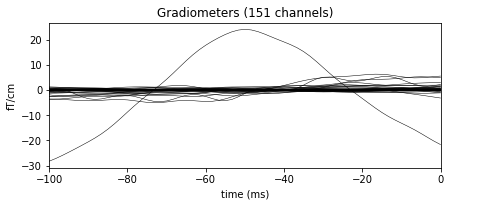

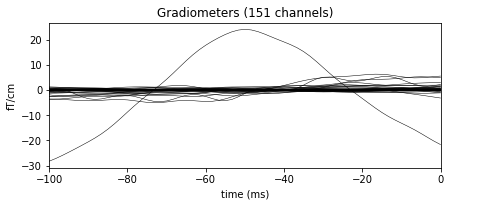

In [16]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
pca = UnsupervisedSpatialFilter(PCA(151), average=False)
pca_data = pca.fit_transform(train_x_array)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(151, 600,
                                     ch_types='grad'), tmin=-0.1)
ev.plot(show=False, window_title="PCA")

/Users/mlion0200/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/mlion0200/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


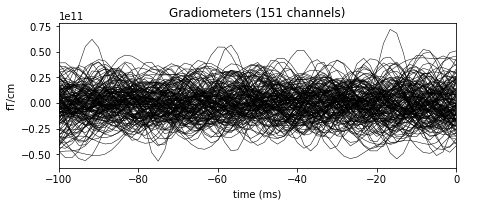

In [17]:
ica = UnsupervisedSpatialFilter(FastICA(151), average=False)
ica_data = ica.fit_transform(train_x_array)
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(151, 600,
                                      ch_types='grad'), tmin=-0.1)
ev1.plot(show=False, window_title='ICA')

plt.show()

In [41]:
train_x_var = np.var(train_x_array, axis=1)
test_x_var = np.var(test_x_array, axis=1)

In [42]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [43]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [44]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [45]:
for name, clf in zip(names, classifiers):
    clf.fit(train_x_var, train_y_array)
    score = clf.score(test_x_var, test_y_array)
    print(name, 'Score: ', score)

Nearest Neighbors Score:  0.85
Linear SVM Score:  0.4
RBF SVM Score:  0.4
Gaussian Process Score:  0.4
Decision Tree Score:  0.4
Random Forest Score:  0.4
Neural Net Score:  0.4
AdaBoost Score:  0.4
Naive Bayes Score:  0.9
QDA Score:  0.4


/Users/mlion0200/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/mlion0200/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [46]:
nb = GaussianNB()
nb.fit(train_x_var, train_y_array)

GaussianNB(priors=None)

In [47]:
print(nb.predict(test_x_var))
print(test_y_array)

[1 1 2 1 1 1 2 2 2 1 1 1 2 2 1 1 1 2 1 2]
[1 2 2 1 1 1 2 2 2 1 1 1 2 2 1 1 1 1 1 2]


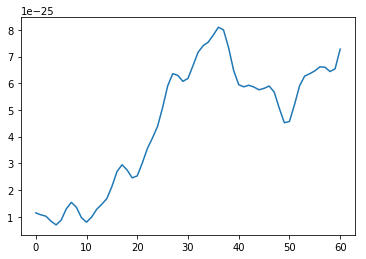

In [63]:
plt.plot(test_x_var[17])

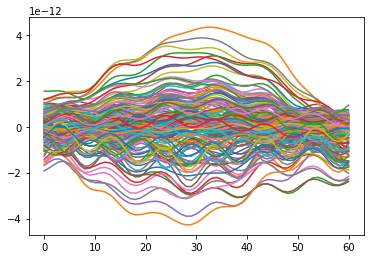

In [69]:
plt.plot(test_x_array[0].T)

In [70]:
from scipy.stats import kurtosis

In [75]:
train_x_kt = kurtosis(train_x_array, axis=1)
test_x_kt = kurtosis(test_x_array, axis=1)

In [76]:
for name, clf in zip(names, classifiers):
    clf.fit(train_x_kt, train_y_array)
    score = clf.score(test_x_kt, test_y_array)
    print(name, 'Score: ', score)

Nearest Neighbors Score:  0.8
Linear SVM Score:  0.65
RBF SVM Score:  0.4
Gaussian Process Score:  0.75
Decision Tree Score:  0.6
Random Forest Score:  0.7
Neural Net Score:  0.65
AdaBoost Score:  0.75
Naive Bayes Score:  0.6
QDA Score:  0.6


/Users/mlion0200/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/mlion0200/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [71]:
kt = kurtosis(train_x_array)

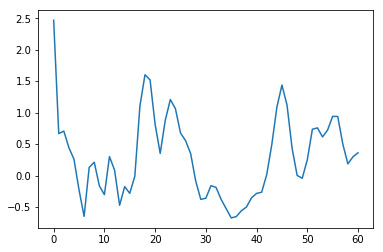

In [74]:
plt.plot(kt[1])